---
title: Fourier Series
description: Drawing any kind of images using Fourier Series.
imgUrl: ./src/notebooks/fourier-series-high-quality.gif
imgAlt: fourier-series
imgSize: '(min-width: 30em) 50vw, 100vw'
pictureClass: grid-column-full
imgClass: img-full

date: "2023-08-12"
tags:
  - Fourier Series
  - Maths
layout: layouts/post.njk


use_katex: true
use_prism: true
---

In [1]:
%pip install svgpathtools moviepy --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def plot(Xs, title=''):
  fig, ax = plt.subplots(1, 1, figsize=(2, 1), dpi=400)
  for X in Xs:
    ax.plot(X.real, X.imag, 'k', lw=0.2)
  ax.set_title(title)
  ax.axis('equal')
  ax.invert_yaxis()
  ax.axis('off')
  return fig, ax

def scatter(Xs, title=''):
  fig, ax = plt.subplots(1, 1, figsize=(2, 1), dpi=400)
  for X in Xs:
    ax.scatter(X.real, X.imag, s=0.1, c='k')
  ax.set_title(title)
  ax.axis('equal')
  ax.invert_yaxis()
  ax.axis('off')
  return fig, ax

# What do we want to do?

We want to create a polynomial function that can plot any kind of 2D image in the complex plane. Several solutions exist, but we will focus on Fourier series.

## First, lets define the input image

We will use svg files as input images as they are easy to parse and can be easily converted to a numpy array. Each svg file contains path elements that define the shape of the image. A path element can be a line, a curve, or a combination of both. We will use the svgpathtools library to parse the svg file and convert it to a numpy array.

> NOTE: svgpathtools allow us to convert any path element to a polynomial function thus solve our problem. However, we will not use this feature as it depends on svg format and we want to be able to plot any kind of image using only sampled points.

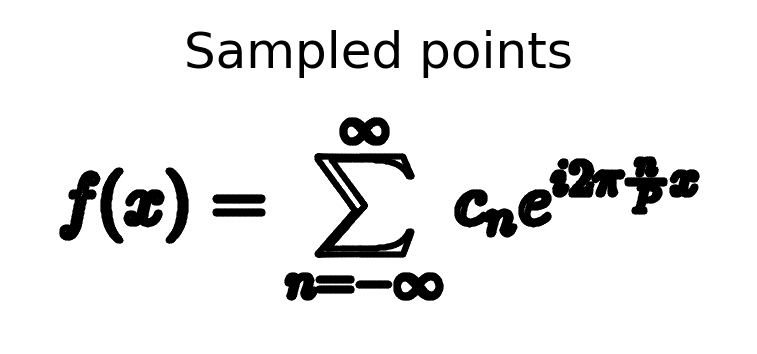

In [3]:
from svgpathtools import svg2paths

N_POINTS = 10000

paths = svg2paths('formula.svg')[0]
total_length = sum(path.length() for path in paths)

def get_nb_points(seg):
  return max(1, int(seg.length() / total_length * N_POINTS))

Xs = [np.hstack([seg.poly()(np.linspace(0, 1, get_nb_points(seg))) for seg in path])
      for path in paths]

def f_gt(tx):
  return [X[(tx*(X.shape[0]-1)).astype(int)] for X in Xs]

scatter(Xs, title='Sampled points');

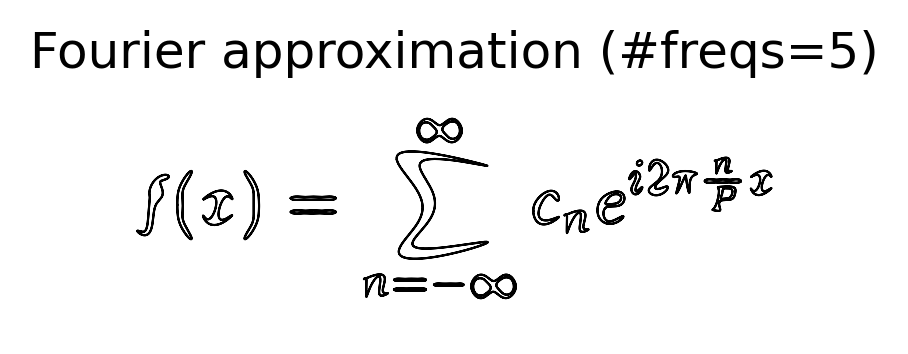

In [4]:
def f_approx(tx, n_freqs=5):
  n = np.arange(-n_freqs, n_freqs+1)
  for fx in f_gt(tx):
    c = np.trapz(np.exp(-2j*np.pi*n[:, None]*tx)*fx)
    yield np.sum(c[:, None]*np.exp(2j*np.pi*n[:, None]*tx), axis=0)

tx = np.linspace(-1, 1, 1000)
fig, ax = plot(f_approx(tx, n_freqs=5), title=f'Fourier approximation (#freqs=5)')

MoviePy - Building file fourier-series.gif with imageio.


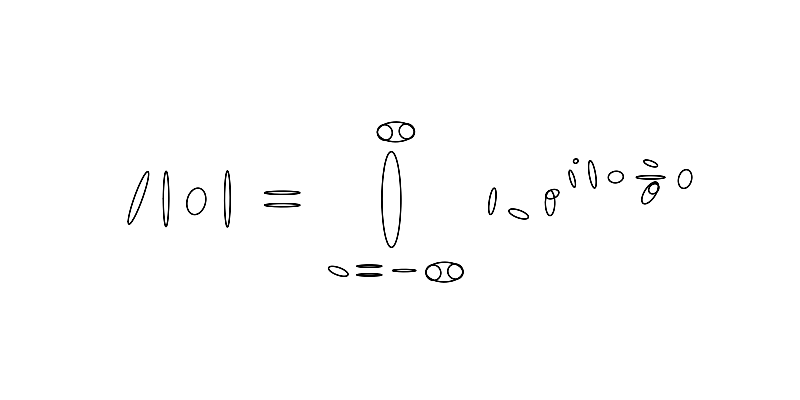

In [14]:
from IPython.display import Image
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

duration = 5
n_freqs_max = 50

tx = np.linspace(-1, 1, 1000)

def make_frame(t):
  n_freqs = max(int(t/duration*n_freqs_max), 1)
  fig, _ = plot(f_approx(tx, n_freqs))
  im = mplfig_to_npimage(fig)
  plt.close(fig)
  return im

clip = mpy.VideoClip(make_frame, duration=duration)
clip.write_gif('fourier-series.gif', fps=15);

display(Image(data=open('fourier-series.gif','rb').read(), format='gif'))